In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [81]:


# Hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 10
temperature = 1.0

# MNIST DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_loader = torch.utils.data.DataLoader(datasets.MNIST('.', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('.', train=False, transform=transform), batch_size=batch_size, shuffle=False)

# Encoder Network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # Output logits for Gumbel-Softmax

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

# Classifier Network
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(10, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Gumbel-Softmax function
def gumbel_softmax(logits, temperature):
    
    return F.gumbel_softmax(logits, tau=1, hard=True)
    
#     noise = torch.rand_like(logits)
#     gumbel_noise = -torch.log(-torch.log(noise + 1e-20) + 1e-20)
#     y = logits + gumbel_noise
#     gumbel_softmax = F.softmax(y / temperature, dim=-1)
#     #values, indices = torch.max(gumbel_softmax, dim=1,keepdims=True)
#     #indices.type(values.dtype)
    
#     topk_values, topk_indices = torch.topk(gumbel_softmax, 3, largest=True, sorted=True)

#     return topk_indices.type(topk_values.dtype)

    

def train(model, device, train_loader, optimizer, epoch):
    model['encoder'].train()
    model['classifier'].train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 28 * 28)
        optimizer.zero_grad()
        logits = model['encoder'](data)  # Call the encoder with data
        gumbel_output = gumbel_softmax(logits, temperature)
        output = model['classifier'](gumbel_output)  # Call the classifier with gumbel_output
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model['encoder'].eval()
    model['classifier'].eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28 * 28)
            logits = model['encoder'](data)  # Call the encoder with data
            gumbel_output = gumbel_softmax(logits, temperature)
            output = model['classifier'](gumbel_output)  # Call the classifier with gumbel_output
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')



In [82]:
# Main code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = {
    'encoder': Encoder().to(device),
    'classifier': Classifier().to(device)
}
optimizer = optim.Adam(list(model['encoder'].parameters()) + list(model['classifier'].parameters()), lr=learning_rate)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282031
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.758531
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.365083
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.109198
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.172204
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.411286
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.124012
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.334688
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.024790
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.009135

Test set: Average loss: 1.0641, Accuracy: 4894/10000 (49%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.032248
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.318942
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.262933
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.877879
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.059275
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.110232
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.819794
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.047435
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.751279
T

In [87]:
def visualize_prediction(model, device, data_loader):
    model['encoder'].eval()
    model['classifier'].eval()
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28 * 28)
            
            # Get logits from encoder
            logits = model['encoder'](data)  # Call the encoder with data
            
            # Apply Gumbel-Softmax
            gumbel_output = gumbel_softmax(logits, temperature)
            
            # Get output from classifier
            output = model['classifier'](gumbel_output)  # Call the classifier with gumbel_output
            
            # Get the predicted class
            pred = output.argmax(dim=1, keepdim=True)
            
            # Determine the grid size
            batch_size = data.size(0)
            grid_size = int(batch_size ** 0.5)
            if grid_size ** 2 < batch_size:
                grid_size += 1
            
            fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
            axes = axes.flatten()
            
            for i in range(batch_size):
                if i < len(axes):
                    axes[i].imshow(data[i].view(28, 28).cpu(), cmap='gray')
                    
                    #gumbel_str = ', '.join([f'{x:.2f}' for x in gumbel_output[i].cpu().numpy()])
#                     axes[i].set_title(f'T: {target[i].item()},[{gumbel_str}], P: {pred[i].item()}')

                    axes[i].set_title(f'T: {target[i].item()},{np.argmax(gumbel_output[i].cpu().numpy())}, P: {pred[i].item()}')
                    
#                     axes[i].set_title(f'T: {target[i].item()} P: {pred[i].item()}')
                    axes[i].axis('off')
                    
#                     # Print the Gumbel-Softmax representation
#                     print(f'Gumbel-Softmax Representation for entry {i}: {gumbel_output[i].cpu().numpy()}')
                    
#                     # Print the classifier output
#                     print(f'Classifier Output for entry {i}: {output[i].cpu().numpy()}')
            
            plt.tight_layout()
            plt.show()
            
            break  # Visualize only one batch for demonstration


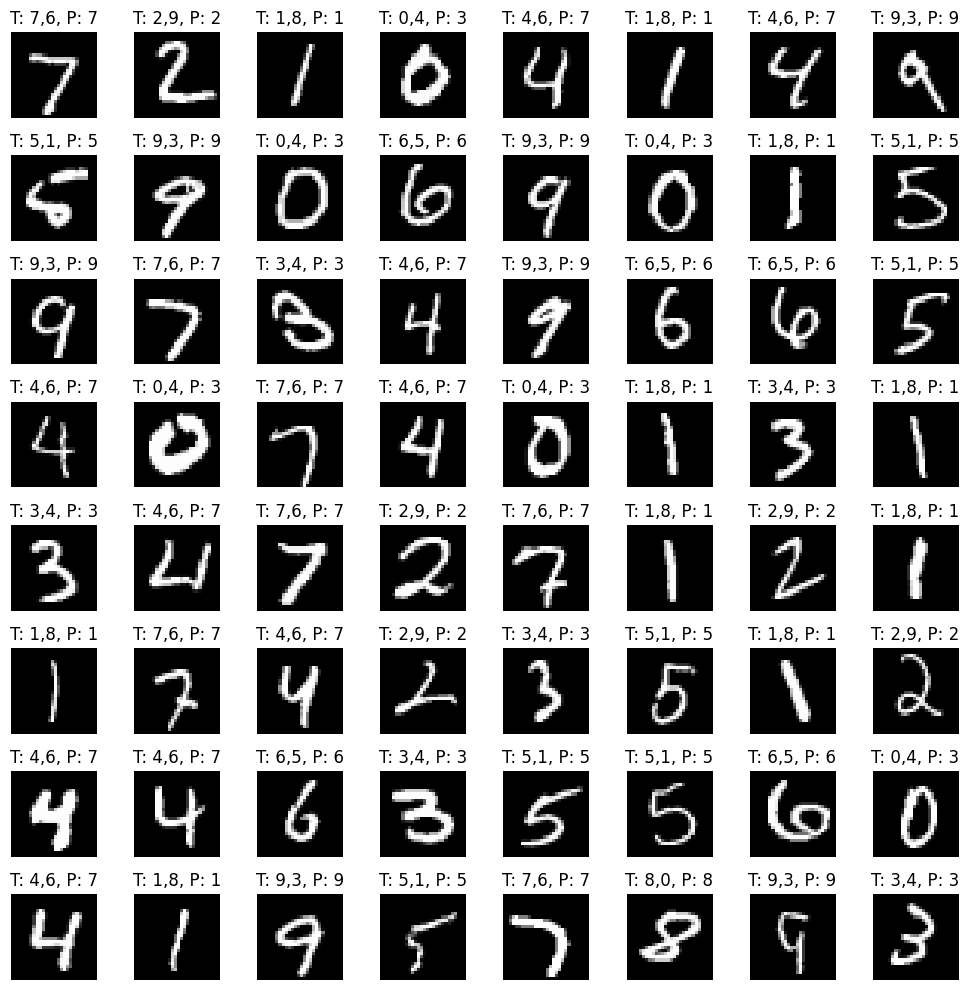

In [88]:
# Visualize a prediction
visualize_prediction(model, device, test_loader)

In [16]:
a = torch.rand(4,4)

In [17]:
a

tensor([[0.2988, 0.3730, 0.6040, 0.9125],
        [0.6192, 0.5321, 0.2061, 0.6658],
        [0.5516, 0.2048, 0.6590, 0.1050],
        [0.3120, 0.7201, 0.8509, 0.1692]])

In [22]:
values, indices = torch.max(a, dim=1,keepdims=True)

In [49]:
indices

tensor([[3],
        [3],
        [2],
        [2]])

In [65]:
topk_values, topk_indices = torch.topk(a, 3, largest=True, sorted=True)

In [76]:
topk_indices

tensor([[3, 2, 1],
        [3, 0, 1],
        [2, 0, 1],
        [2, 1, 0]])